In [4]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import pywt

from cuda_hspme import Wavelet_Transform

%reload_ext autoreload
%autoreload 2

In [5]:
import pycuda.driver as cuda
from six.moves import range

# load devices and check some limitations

cuda.init()
print("%d device(s) found." % cuda.Device.count())
 
# for ordinal in range(cuda.Device.count()):
#     dev = cuda.Device(ordinal)
#     print('Device #%d: %s' % (ordinal, dev.name()))
#     print(' Compute Capability: %d.%d' % dev.compute_capability())
#     print(' Total Memory: %s KB' % (dev.total_memory()//(1024)))
 
#     atts = [ (str(att), value) for att, value in list(dev.get_attributes().items())]
#     atts.sort()
 
#     for att, value in atts:
#         print(' %s : %s' % (att, value))

1 device(s) found.


### A note for some limitations

<br/>MAX_BLOCK_DIM_X : 1024
<br/>MAX_GRID_DIM_X : 2147483647
<br/>MAX_THREADS_PER_BLOCK : 1024
<br/>MAX_THREADS_PER_MULTIPROCESSOR : 1024

<br/>TOTAL_CONSTANT_MEMORY : 65536 Byte = 64KB
<br/>MAX_SHARED_MEMORY_PER_BLOCK : 49152 Byte = 48KB
<br/>MAX_SHARED_MEMORY_PER_MULTIPROCESSOR : 65536 Byte = 64KB
<br/>MAX_REGISTERS_PER_BLOCK : 65536



# 1. Test of generation of masks

In [52]:
# Test function to analyse mask generation in different scales
def runtime_analysis_mask(max_scale, wvtr):
    print("Processing scale", max_scale)
    scales = np.arange(1,max_scale)
    
    # gpu improved implementation
    gpu_masks, gpu_mask_lengths, gpu_mask_time = wvtr.gpu_generate_mask_1b1s(scales)
    # gpu naive implementation
    gpu_naive_masks, gpu_naive_mask_lengths, gpu_naive_mask_time = wvtr.gpu_generate_mask(scales)
    # cpu implementation
    py_masks, py_mask_time = wvtr.py_generate_mask(scales)
    
    # evaluate difference between gpu & cpu masks
    py_masks_flatten = [i for item in py_masks for i in item]
    diff = np.mean((gpu_masks - py_masks_flatten)/py_masks_flatten)*100
    
    return py_mask_time, gpu_naive_mask_time, gpu_mask_time, diff

In [53]:
# test of mask generation
print("="*10, "Test of mask generation","="*10)
wvtr = Wavelet_Transform('morl', "./kernel_code.txt")
max_scales = [16, 64, 256, 1024, 4096]
py_mask_time_list = []
gpu_simple_mask_time_list = []
gpu_mask_time_list = []
diff_list = []

for max_scale in max_scales:
    py_mask_time, gpu_naive_mask_time, gpu_mask_time, diff = runtime_analysis_mask(max_scale, wvtr)
    py_mask_time_list.append(py_mask_time)
    gpu_simple_mask_time_list.append(gpu_naive_mask_time)
    gpu_mask_time_list.append(gpu_mask_time)
    diff_list.append(diff)
    
print("Complete!")

========== Test of mask generation ==========
Processing scale 16
Processing scale 64
Processing scale 256
Processing scale 1024
Processing scale 4096
Complete!


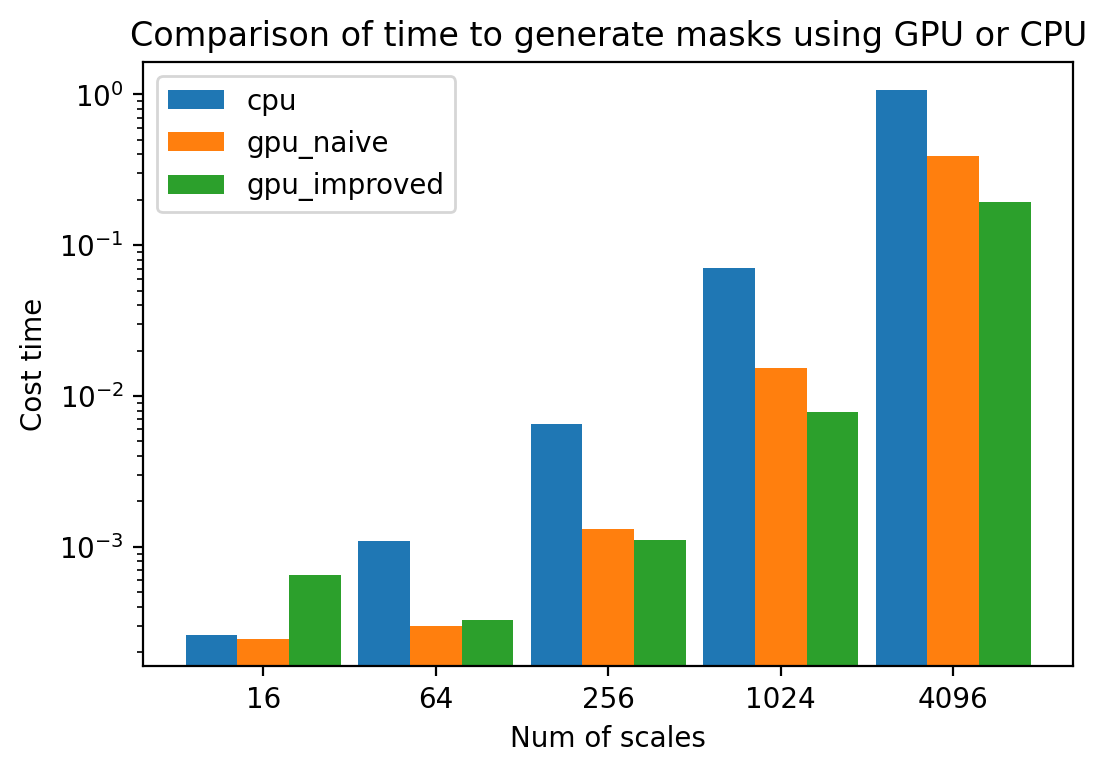

In [54]:
# visualize the running time 
plt.figure(figsize=[6,4], dpi=200)
plt.axes(yscale = "log") 
bar_width=0.3
x = np.arange(len(max_scales))

plt.bar(x, py_mask_time_list, bar_width)
plt.bar(x+bar_width, gpu_simple_mask_time_list, bar_width)
plt.bar(x+2*bar_width, gpu_mask_time_list, bar_width)
plt.xticks(x+bar_width,max_scales)

plt.legend(['cpu', 'gpu_naive', 'gpu_improved'])
plt.xlabel("Num of scales")
plt.ylabel("Cost time")
plt.title("Comparison of time to generate masks using GPU or CPU")
plt.savefig('./figures/mask_generation_test.png', bbox_inches='tight')

In [24]:
# table results for speed up ratio
# there are some randomness, so the output may not perfectly match with result in final report but should be similar
res_mask_dict = {}
res_mask_dict['speed_up_over_cpu'] = np.array(py_mask_time_list)/np.array(gpu_mask_time_list)
res_mask_dict['speed_up_over_simple'] = np.array(gpu_simple_mask_time_list)/np.array(gpu_mask_time_list)
res_mask_dict['diff'] = np.array(diff_list)

res_mask_pd = pd.DataFrame.from_dict(res_mask_dict, orient='index')
res_mask_pd.columns = max_scales
print(res_mask_pd)

                          16        64        256       1024       4096
speed_up_over_cpu     0.360502  5.263517  5.233904  8.689847  10.017046
speed_up_over_simple  0.160846  0.829843  1.487480  2.123523   3.049893
diff                  0.000000  0.000000 -0.000138  0.000003   0.000023


# 2. Test of multi-convolutions (runtime)

## Table

In [28]:
# function to compute speed up ratio
def runtime_analysis_whole(max_scale, input_length, wvtr):
    # define scale and input signal
    scales = np.arange(1,max_scale)
    demo_sig = pywt.data.demo_signal('Doppler', n=input_length)
    
    # gpu wavelet transform
    gpu_masks, gpu_mask_lengths, gpu_mask_time = wvtr.gpu_generate_mask_1b1s(scales)
    gpu_conv_results, t = wvtr.multiresolution_conv(demo_sig, gpu_masks, gpu_mask_lengths, scales)
    
    # cpu wavelet transform
    py_masks, py_mask_time = wvtr.py_generate_mask(scales)
    py_conv_results, py_conv_time = wvtr.py_convolve(demo_sig, py_masks)
    
    # compute speed up ratio
#     print('Accelerate:',py_conv_time/t)    
    return py_conv_time/t

In [37]:
# generate speed up table
wvtr = Wavelet_Transform('morl', "kernel_code.txt")
max_scales = [16, 64, 128, 200]
input_lengths = [1024, 10240, 51200, 102400]
res_conv_dict = {}

for max_scale in max_scales:
    temp = []
    for input_length in input_lengths:
        print("Processing num_scales:{}, input_length:{}".format(max_scale, input_length))
        speed_up = runtime_analysis_whole(max_scale, input_length, wvtr)
        temp.append(speed_up)
    res_conv_dict[max_scale] = temp

Processing num_scales:16, input_length:1024
Processing num_scales:16, input_length:10240
Processing num_scales:16, input_length:51200
Processing num_scales:16, input_length:102400
Processing num_scales:64, input_length:1024
Processing num_scales:64, input_length:10240
Processing num_scales:64, input_length:51200
Processing num_scales:64, input_length:102400
Processing num_scales:128, input_length:1024
Processing num_scales:128, input_length:10240
Processing num_scales:128, input_length:51200
Processing num_scales:128, input_length:102400
Processing num_scales:200, input_length:1024
Processing num_scales:200, input_length:10240
Processing num_scales:200, input_length:51200
Processing num_scales:200, input_length:102400


In [38]:
# table results for speed up ratio
# there are some randomness, so the output may not perfectly match with result in final report but should be similar
res_conv_pd = pd.DataFrame.from_dict(res_conv_dict, orient='index')
res_conv_pd.columns = input_lengths
print(res_conv_pd)

       1024      10240     51200     102400
16   0.148200  1.130546  2.048597  2.526008
64   0.083955  0.903591  2.160010  2.347794
128  0.350504  3.958118  4.152987  4.499728
200  0.161630  6.685578  7.241424  7.525633


# Plot

In [43]:
# function to compute runtime for plotting
# add conv simple
def runtime_analysis_seperate(max_scale, input_length, wvtr):
    # define scale and input signal
    scales = np.arange(1,max_scale)
    demo_sig = pywt.data.demo_signal('Doppler', n=input_length)
    
    # gpu wavelet transform
    gpu_masks, gpu_mask_lengths, _ = wvtr.gpu_generate_mask_1b1s(scales)
    _, gpu_time = wvtr.multiresolution_conv(demo_sig, gpu_masks, gpu_mask_lengths, scales)
    
    # gpu naive wavelet transform
    masks, mask_lengths, _ = wvtr.gpu_generate_mask(scales)
    _, gpu_naive_time = wvtr.gpu_convolve(demo_sig, masks, mask_lengths)
    
    # cpu wavelet transform
    py_masks, _ = wvtr.py_generate_mask(scales)
    _, py_conv_time = wvtr.py_convolve(demo_sig, py_masks)
    
    # compute speed up ratio
#     print('Accelerate:',py_conv_time/t)    
    return gpu_time, gpu_naive_time, py_conv_time

In [50]:
# fix max scale, change input lengths
print("="*10, "Test of Multiple Convolutions over input lengths","="*10)
wvtr = Wavelet_Transform('morl', "kernel_code.txt")
max_scale = 200
input_lengths = [1024, 10240, 51200, 102400]
py_conv_time_list = []
gpu_simple_conv_time_list = []
gpu_conv_time_list = []

for input_length in input_lengths:
    print("Processing input_length:{}".format(input_length))
    gpu_time, gpu_naive_time, py_conv_time = runtime_analysis_seperate(max_scale, input_length, wvtr)
    
    py_conv_time_list.append(py_conv_time)
    gpu_simple_conv_time_list.append(gpu_time)
    gpu_conv_time_list.append(gpu_naive_time)

print("Complete!")

========== Test of Multiple Convolutions over input lengths ==========
Processing input_length:1024
Processing input_length:10240
Processing input_length:51200
Processing input_length:102400
Complete!


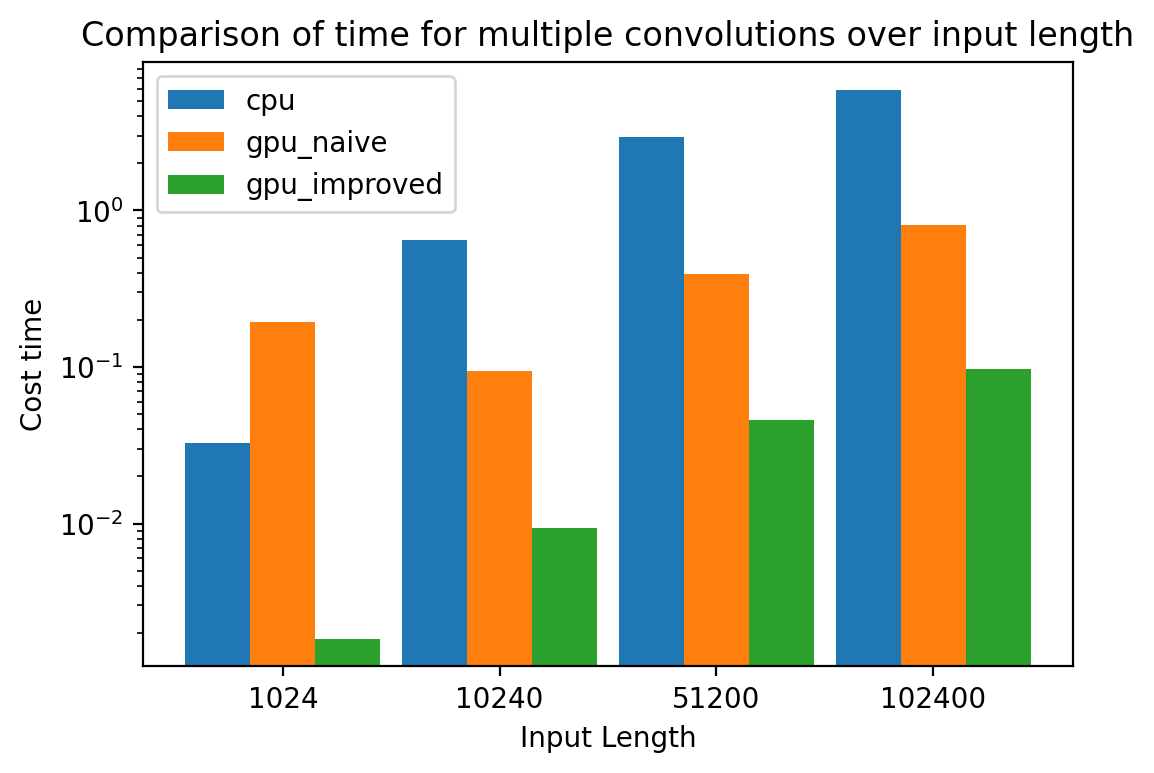

In [56]:
# visualize the running time 
plt.figure(figsize=[6,4], dpi=200)
plt.axes(yscale = "log") 
bar_width=0.3
x = np.arange(len(input_lengths))

plt.bar(x, py_conv_time_list, bar_width)
plt.bar(x+bar_width, gpu_simple_conv_time_list, bar_width)
plt.bar(x+2*bar_width, gpu_conv_time_list, bar_width)
plt.xticks(x+bar_width, input_lengths)

plt.legend(['cpu', 'gpu_naive', 'gpu_improved'])
plt.xlabel("Input Length")
plt.ylabel("Cost time")
plt.title("Comparison of time for multiple convolutions over input length")
plt.savefig('./figures/multi_convolution_over_input.png', bbox_inches='tight')

In [58]:
# fix max scale, change input lengths
print("="*10, "Test of Multiple Convolutions over number of scales","="*10)
wvtr = Wavelet_Transform('morl', "kernel_code.txt")
max_scales = [16, 64, 128, 200]
input_length = 102400
py_conv_time_list = []
gpu_simple_conv_time_list = []
gpu_conv_time_list = []

for max_scale in max_scales:
    print("Processing num_scales:{}".format(max_scale))
    gpu_time, gpu_naive_time, py_conv_time = runtime_analysis_seperate(max_scale, input_length, wvtr)
    
    py_conv_time_list.append(py_conv_time)
    gpu_simple_conv_time_list.append(gpu_time)
    gpu_conv_time_list.append(gpu_naive_time)

print("Complete!")

========== Test of Multiple Convolutions over number of scales ==========
Processing num_scales:16
Processing num_scales:64
Processing num_scales:128
Processing num_scales:200
Complete!


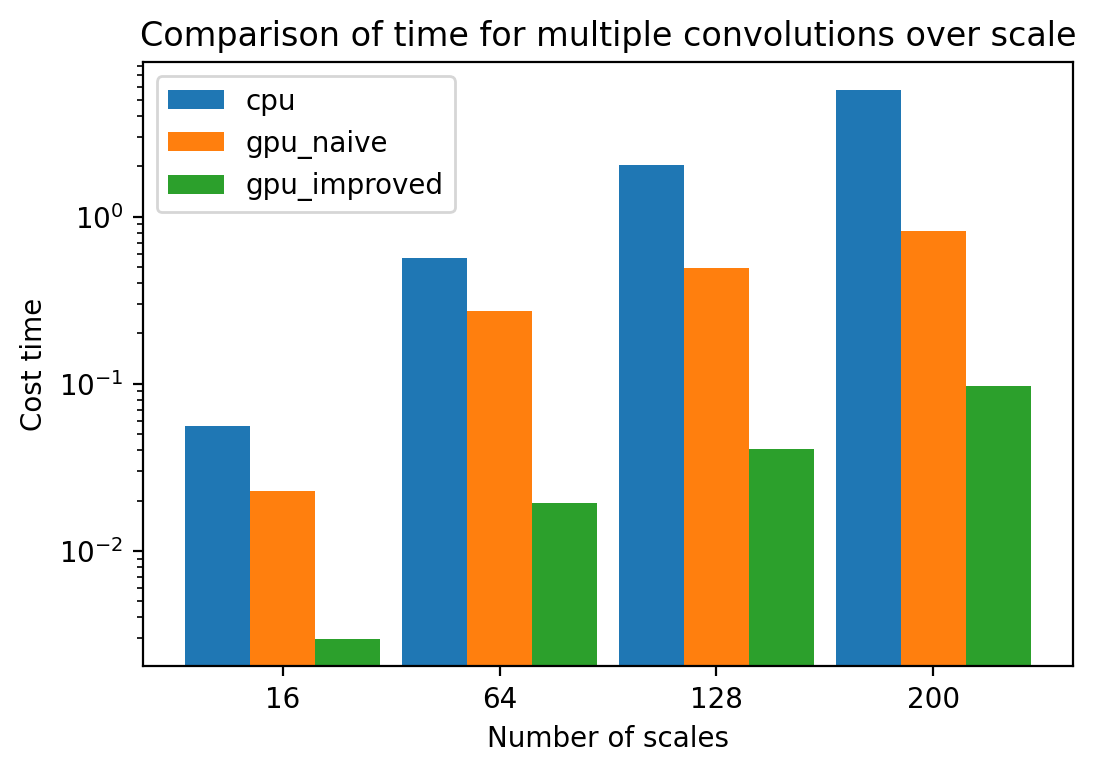

In [59]:
# visualize the running time 
plt.figure(figsize=[6,4], dpi=200)
plt.axes(yscale = "log") 
bar_width=0.3
x = np.arange(len(max_scales))

plt.bar(x, py_conv_time_list, bar_width)
plt.bar(x+bar_width, gpu_simple_conv_time_list, bar_width)
plt.bar(x+2*bar_width, gpu_conv_time_list, bar_width)
plt.xticks(x+bar_width, max_scales)

plt.legend(['cpu', 'gpu_naive', 'gpu_improved'])
plt.xlabel("Number of scales")
plt.ylabel("Cost time")
plt.title("Comparison of time for multiple convolutions over scale")
plt.savefig('./figures/multi_convolution_over_scale.png', bbox_inches='tight')

# 3. Test of multi-convolutions (numeric stability)

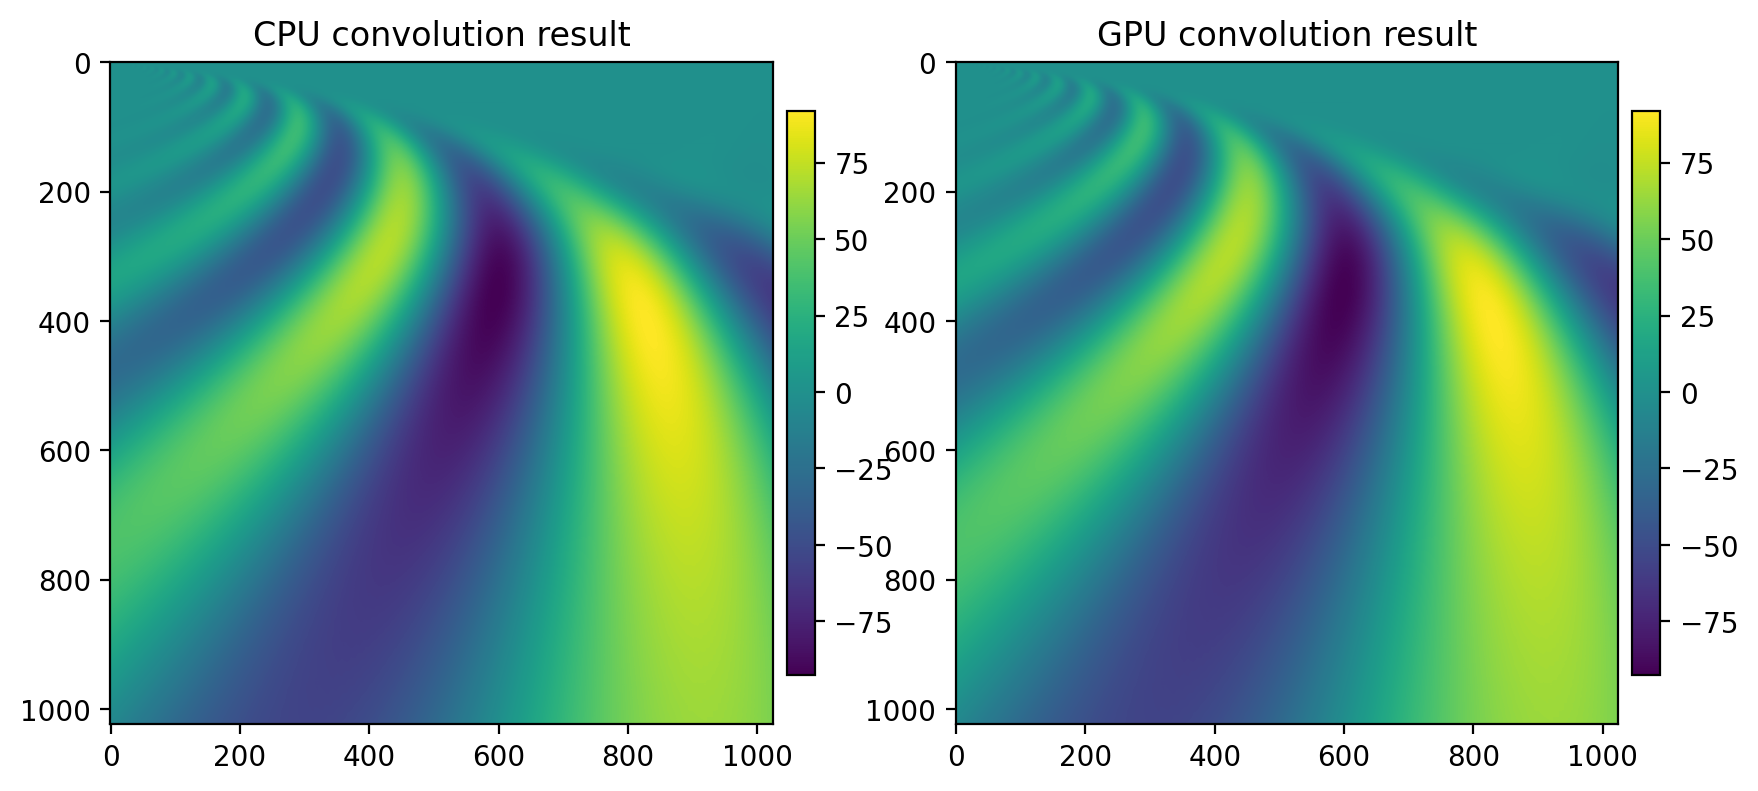

In [3]:
demo_sig = pywt.data.demo_signal('Doppler', n=1024)
scales = np.arange(1,1024)
wvtr = Wavelet_Transform('morl', "kernel_code.txt")
py_masks, _ = wvtr.py_generate_mask(scales)
py_conv_results, _ = wvtr.py_convolve(demo_sig, py_masks)
masks, mask_lengths, _ = wvtr.gpu_generate_mask(scales)
gpu_conv_results, _ = wvtr.gpu_convolve(demo_sig, masks, mask_lengths)

plt.figure(figsize=[10,10], dpi=200)
plt.subplot(1,2,1)
plt.imshow(py_conv_results)
plt.colorbar(fraction=0.04, pad=0.02)
plt.title("CPU convolution result")
plt.subplot(1,2,2)
plt.imshow(gpu_conv_results)
plt.title("GPU convolution result")
plt.colorbar(fraction=0.04, pad=0.02)
plt.savefig("./figures/conv_result.png", bbox_inches='tight')

In [25]:
# function to compute speed up ratio
def precision_analysis(max_scale, input_length, wvtr):
    # define scale and input signal
    scales = np.arange(1,max_scale)
    demo_sig = pywt.data.demo_signal('Doppler', n=input_length)
    
    # gpu wavelet transform
    masks, mask_lengths, _ = wvtr.gpu_generate_mask(scales)
    gpu_conv_results, _ = wvtr.gpu_convolve(demo_sig, masks, mask_lengths)
    
    # cpu wavelet transform
    py_masks, py_mask_time = wvtr.py_generate_mask(scales)
    py_conv_results, py_conv_time = wvtr.py_convolve(demo_sig, py_masks)
    
    # compute respective difference
    # keep it to two decimal places
    return np.round(np.mean((gpu_conv_results - py_conv_results)/py_conv_results * 100),2)

In [26]:
print("="*10, "Test of Multiple Convolutions Precision","="*10)
# generate precision table
wvtr = Wavelet_Transform('morl', "kernel_code.txt")
max_scales = [16, 64, 128, 200]
input_lengths = [1024, 10240, 51200, 102400]
res_prec_dict = {}

for max_scale in max_scales:
    temp = []
    for input_length in input_lengths:
        print("Processing num_scales:{}, input_length:{}".format(max_scale, input_length))
        diff = precision_analysis(max_scale, input_length, wvtr)
        temp.append(diff)
    res_prec_dict[max_scale] = temp
print("Complete!")

========== Test of Multiple Convolutions Precision ==========
Processing num_scales:16, input_length:1024
Processing num_scales:16, input_length:10240
Processing num_scales:16, input_length:51200
Processing num_scales:16, input_length:102400
Processing num_scales:64, input_length:1024
Processing num_scales:64, input_length:10240
Processing num_scales:64, input_length:51200
Processing num_scales:64, input_length:102400
Processing num_scales:128, input_length:1024
Processing num_scales:128, input_length:10240
Processing num_scales:128, input_length:51200
Processing num_scales:128, input_length:102400
Processing num_scales:200, input_length:1024
Processing num_scales:200, input_length:10240
Processing num_scales:200, input_length:51200
Processing num_scales:200, input_length:102400
Complete!


In [27]:
# table results for respective difference
# there are some randomness, so the output may not perfectly match with result in final report but should be similar
res_prec_pd = pd.DataFrame.from_dict(res_prec_dict, orient='index')
res_prec_pd.columns = input_lengths
print(res_prec_pd)

     1024    10240   51200   102400
16    -0.00   -0.00   -0.01    0.00
64    -0.00    0.00   -0.02    0.02
128   -0.01   -0.02   -0.02    0.01
200   -0.00    0.19   -0.03   -0.11


In [9]:
# extra test with oversampling
wvtr = Wavelet_Transform('morl', "kernel_code.txt")
sample_input = np.array([1,2,3,4])
wvtr.oversampling(sample_input, 4)

array([1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0])